In [3]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/sil_consistent_at_inference')
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/sil_consistent_at_inference


In [4]:
# imports
import pprint
import pickle
import glob
import random
from pathlib import Path

import torch
from tqdm import tqdm
from PIL import Image
import numpy as np
from pytorch3d.renderer import (
    look_at_view_transform
)
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np

from utils import general_utils
import deformation.losses as def_losses
from utils.visualization_tools import show_refinement_results


In [5]:
def get_exp_path(exp_name):
    if os.path.exists(os.path.join("out",exp_name)):
        return exp_name
    
    if exp_name == "latest":
        exp_paths = []
        for root, dirs, files in os.walk("out"):
            for d in dirs:
                if "--" in d and len(os.path.join(root,d).split('/'))==2:
                    exp_paths.append(d)
        return sorted(exp_paths)[-1]
    
    exp_path = []
    for root, dirs, files in os.walk("out"):
        for d in dirs:
            if exp_name == d[21:] and len(os.path.join(root,d).split('/'))==2:
                exp_path.append(d)
    if len(exp_path) > 1:
        print(exp_path)
        raise Exception("multiple experiments with that name")
    elif len(exp_path) == 0:
        raise Exception("Couldn't find any matching experiments")
    else:
        return exp_path[0]

In [6]:
gpu_num = 0
device = torch.device("cuda:"+str(gpu_num))
cfg_path = "configs/test.yaml"
cfg = general_utils.load_config(cfg_path, "configs/default.yaml")

# Show Adversarial Training Info

out/2020_11_29--08_50_23_job_02
False


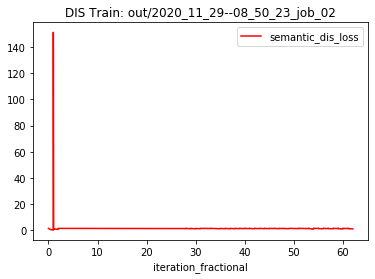

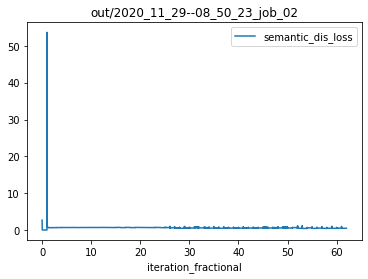

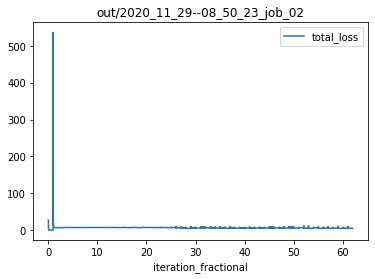

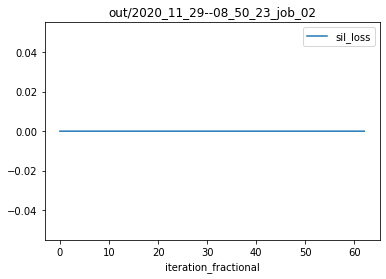

In [8]:
#n="latest"
n="job_02"
saved_model_path = "out/{}".format(get_exp_path(n))
print(saved_model_path)


# show training plots
training_info = pickle.load(open(os.path.join(saved_model_path, "training_df.p"), "rb"))

# showing discriminator plots
semantic_dis_training_df = training_info["semantic_dis"]
if not semantic_dis_training_df.empty:
    # adding extra column for fracitional iteration
    iteration_fractional = np.linspace(0, max(semantic_dis_training_df['iteration'])+1, len(semantic_dis_training_df)+1)[:-1]
    semantic_dis_training_df["iteration_fractional"] = iteration_fractional
    
    print(semantic_dis_training_df.isnull().values.any())
    
    #pd.set_option('display.max_rows', None)  
    #display(semantic_dis_training_df)
    semantic_dis_training_df.plot.line(x="iteration_fractional", y="semantic_dis_loss", title="DIS Train: " + saved_model_path, color='r')
    #semantic_dis_training_df.plot.line(x="iteration_fractional", y="batch_avg_dis_acc", title="DIS Train: " + saved_model_path, color='r')

# showing generator (deformation net) plots
deform_gen_training_df = training_info["deform_net_gen"]
if not deform_gen_training_df.empty:
    iteration_fractional = np.linspace(0, max(deform_gen_training_df['iteration'])+1, len(deform_gen_training_df)+1)[:-1]
    deform_gen_training_df["iteration_fractional"] = iteration_fractional
    #display(deform_gen_training_df)

    deform_gen_training_df.plot.line(x="iteration_fractional", y="semantic_dis_loss", title=saved_model_path)
    deform_gen_training_df.plot.line(x="iteration_fractional", y="total_loss", title=saved_model_path)
    deform_gen_training_df.plot.line(x="iteration_fractional", y="sil_loss", title=saved_model_path)

# Show Adversarial Training Results

In [18]:
# displays meshes at the predicted pose
def show_meshes(cfg, device, saved_model_path, only_show_instances=[], num_novel_view=3):
    input_dir_img = cfg['semantic_dis_training']['gen_dir_img']
    input_dir_mesh = cfg['semantic_dis_training']['gen_dir_mesh']
    
    cached_pred_poses = pickle.load(open(cfg['semantic_dis_training']["gen_poses"], "rb"))
    
    # getting paths of all processed meshes, keyed by instance name
    processed_paths = list(Path(saved_model_path).rglob('*.obj'))
    processed_paths_dict = {}
    for path in processed_paths:
        instance_name = str(path).split('/')[-1][:-4]
        if instance_name not in processed_paths_dict:
            processed_paths_dict[instance_name] = [path]
        else:
            processed_paths_dict[instance_name].append(path)
    
    for instance_name in processed_paths_dict:
        if len(only_show_instances) == 0 or instance_name in only_show_instances:
            for processed_mesh_path in sorted(processed_paths_dict[instance_name], key= lambda x : int(str(x).split('/')[-2].replace("eval_", ""))):
            
                input_image = Image.open(os.path.join(input_dir_img, instance_name+".png"))
                with torch.no_grad():
                    mesh_original = general_utils.load_untextured_mesh(os.path.join(input_dir_mesh, instance_name+".obj"), device)
                    mesh_processed = general_utils.load_untextured_mesh(processed_mesh_path, device)

                # rendering original and processed mesh at predicted pose
                pred_dist = cached_pred_poses[instance_name]['dist']
                pred_elev = cached_pred_poses[instance_name]['elev']
                pred_azim = cached_pred_poses[instance_name]['azim']
                
                show_refinement_results(input_image, mesh_original, mesh_processed, pred_dist, pred_elev, pred_azim, device)

['eval_0', 'eval_1', 'eval_2', 'eval_3', 'eval_4', 'eval_5', 'eval_6', 'eval_7', 'eval_8', 'eval_9']
Latest eval dir: out/2020_11_28--04_25_54_job_01/eval_9



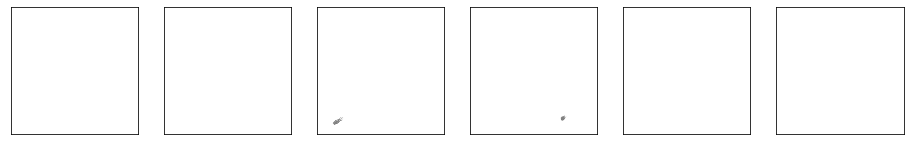

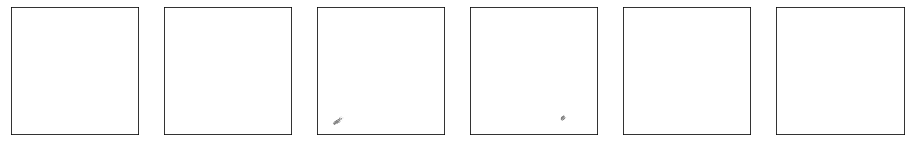

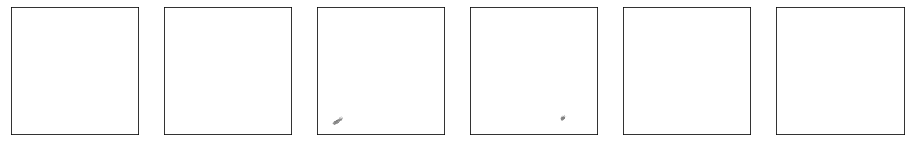

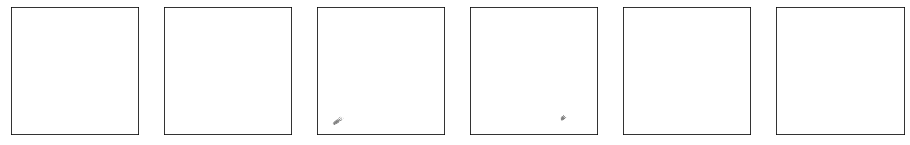

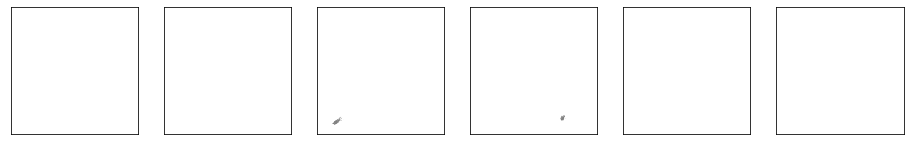

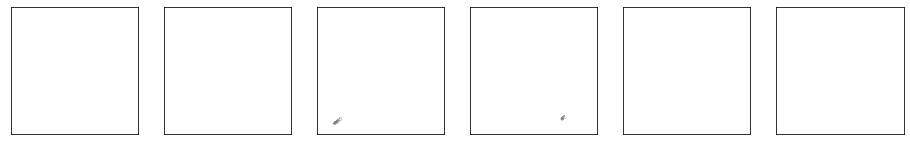

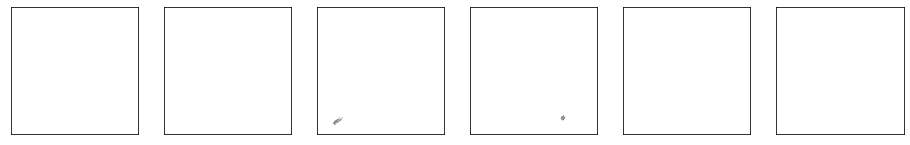

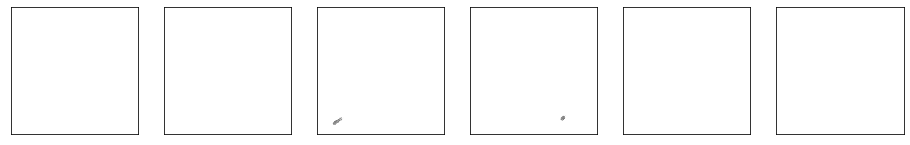

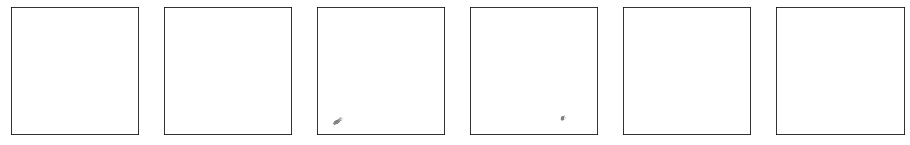

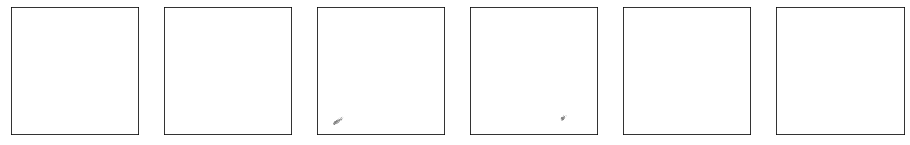

In [19]:
# show all latest meshes
eval_dirs = []
for root, dirs, files in os.walk(saved_model_path):
    for d in dirs:
        if "eval_" in d:
            eval_dirs.append(d)
eval_dirs = sorted(eval_dirs, key= lambda x: int(x.replace("eval_", "")))
print(eval_dirs)
latest_eval_dir = os.path.join(saved_model_path, eval_dirs[-1])
print("Latest eval dir: {}\n".format(latest_eval_dir))

show_meshes(cfg, device, latest_eval_dir)


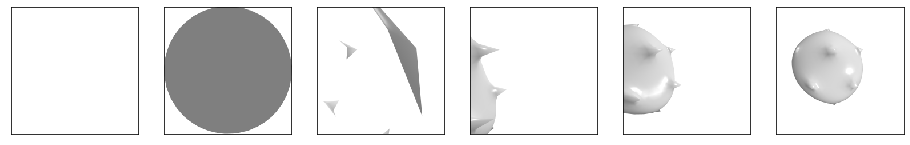

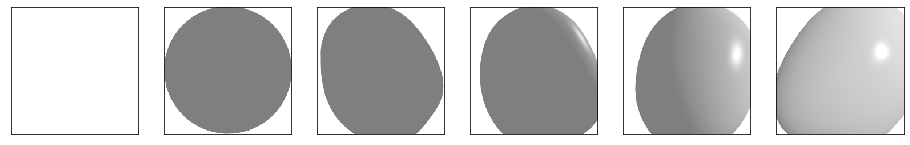

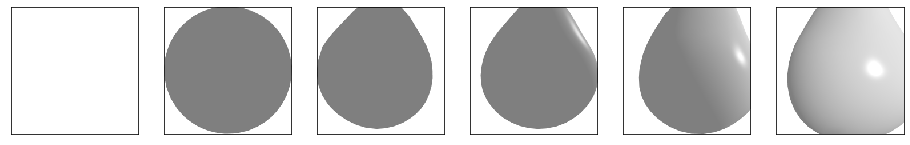

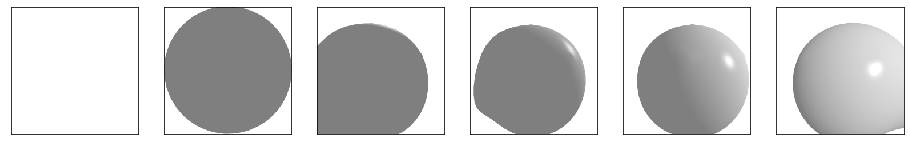

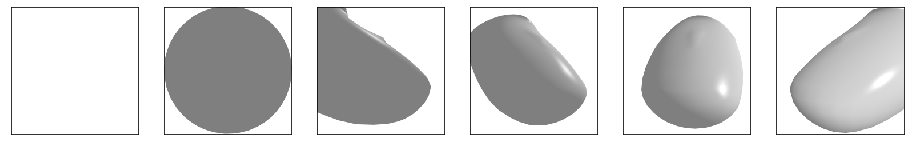

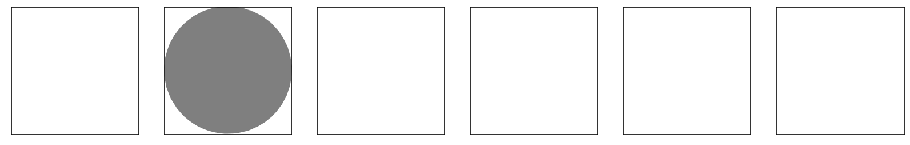

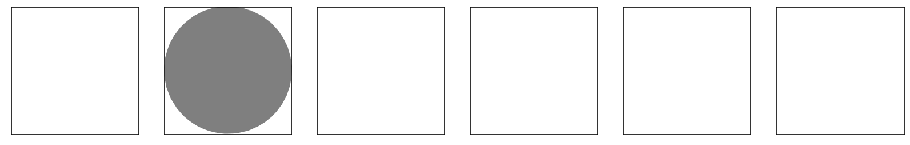

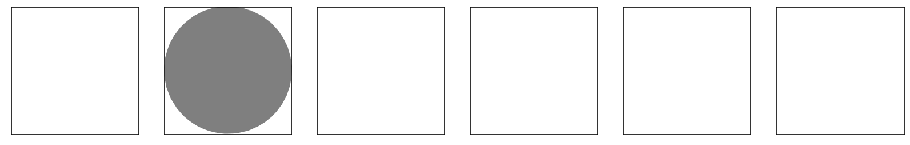

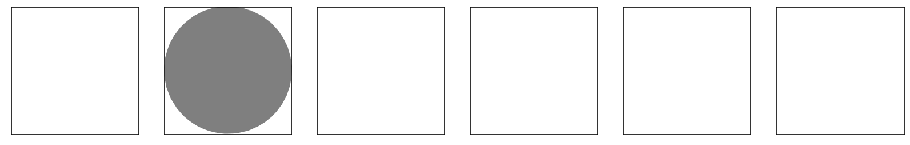

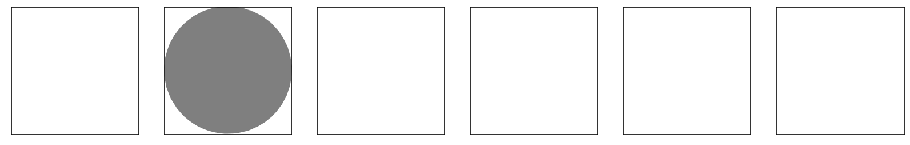

In [38]:
# show a mesh throughout iterations
instance_to_show = "sphere_642"
show_meshes(cfg, device, saved_model_path, [instance_to_show])

In [23]:
import torch.nn as nn

m = nn.utils.spectral_norm(nn.Linear(20, 40))